In [13]:
from zoish.feature_selectors.gridshap import GridSearchCVShapFeatureSelector
import logging
import numpy as np
import pandas as pd
import xgboost
import xgbse
from xgbse.converters import convert_to_structured
from xgbse.metrics import concordance_index, approx_brier_score
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold,train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score)


# Install pytorch, pycox needs it

In [14]:
!pip3 install torch torchvision torchaudio



[notice] A new release of pip available: 22.1.2 -> 22.2.2
[notice] To update, run: pip install --upgrade pip


# Example : XGBoost Survival Embeddings (XGBSEKaplanNeighbors)
For more information refer to this link :
https://loft-br.github.io/xgboost-survival-embeddings/examples/confidence_interval.html

# Data

In [15]:
from pycox.datasets import metabric
# read data metabric
data = metabric.read_df()
data.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,duration,event
0,5.603834,7.811392,10.797988,5.967607,1.0,1.0,0.0,1.0,56.840000,99.333336,0
1,5.284882,9.581043,10.204620,5.664970,1.0,0.0,0.0,1.0,85.940002,95.733330,1
2,5.920251,6.776564,12.431715,5.873857,0.0,1.0,0.0,1.0,48.439999,140.233337,0
3,6.654017,5.341846,8.646379,5.655888,0.0,0.0,0.0,0.0,66.910004,239.300003,0
4,5.456747,5.339741,10.555724,6.008429,1.0,0.0,0.0,1.0,67.849998,56.933334,1


# Define labels in this example: 

y for feature selection (if you want to feature selection based on event)
y_fs = data['event']

Also in grid_xgbse bellow,  xgbse_focus should be set = "event",


y for feature selection (if you want to perform feature selection based on duration)
y_fs = data['duration']

Also in grid_xgbse bellow,  xgbse_focus should be set = "duration",



In [16]:

# splitting to X, T, E format
X = data.drop(['duration', 'event'], axis=1)
T = data['duration']
E = data['event']
y = convert_to_structured(T, E)
# y for for feature selection (if you want do feature selection based on event)
# y_fs = data[['event']]
# also in grid_xgbse should set xgbse_model_needed = "classification",


# y for for feature selection (if you want do feature selection based on duration)
# y_fs = data[['duration']]
# also in grid_xgbse should set xgbse_model_needed = "regression",

y_fs = data[['duration']]



In [17]:
y_fs.head()

,duration
0,99.333336
1,95.733330
2,140.233337
3,239.300003
4,56.933334


# Train test split for feature selection and for the model itself

splitting between train and validation (the following uses for the feature selection step - random_state should be the same in both)
 - X_train, X_test, y_train_fs, y_test_fs = train_test_split(X, y_fs, test_size=1/3, random_state = 0)

splitting between train and validation (the following uses for the main model - random_state should be the same in both)
- _ , _ , y_train, y_test = train_test_split(X, y, test_size=1/3, random_state = 0)


In [18]:
# splitting between train, and validation (the following is for feature selection step - random_state should be same in both)
X_train, X_test, y_train_fs, y_test_fs = train_test_split(X, y_fs, test_size=1/3, random_state = 0)
# splitting between train, and validation (the following is for fit main model - random_state should be same in both)
_ , _ , y_train, y_test = train_test_split(X, y, test_size=1/3, random_state = 0)

TIME_BINS = np.arange(15, 315, 15)
TIME_BINS


array([ 15,  30,  45,  60,  75,  90, 105, 120, 135, 150, 165, 180, 195,
       210, 225, 240, 255, 270, 285, 300])

# Define Feature selector and set its arguments  

The feature selector in this example (or when the focus is on "duration") will use XGBRegressor.

So estimator_params should be matched with XGBRegressor.

In [19]:
grid_xgbse = GridSearchCVShapFeatureSelector(
        # general argument setting        
        verbose=5,
        random_state=0,
        logging_basicConfig = None,
        # general argument setting        
        n_features=5,
        list_of_obligatory_features_that_must_be_in_model=[],
        list_of_features_to_drop_before_any_selection=[],
        # shap argument setting        
        estimator=xgbse.XGBSEKaplanNeighbors(),
        estimator_params={
        "max_depth": [4, 5],
        "min_child_weight": [0.1, 0.9],
        "gamma": [1, 9],
        },
        # shap arguments
        model_output="raw", 
        feature_perturbation="interventional", 
        algorithm="auto", 
        shap_n_jobs=-1, 
        memory_tolerance=-1, 
        feature_names=None, 
        approximate=False, 
        shortcut=False, 
        plot_shap_summary=True,
        save_shap_summary_plot=False,
        path_to_save_plot = './summary_plot.png',
        shap_fig = plt.figure(),
        ## grid search params
        performance_metric = 'r2',
        cv = KFold(n_splits=3, shuffle=True),
        # this argument is necessary and only 
        # meaningful for Survival Embedding
        xgbse_focus = "duration",

)


root - INFO - Setting value for logging_basicConfig
root - INFO - Getting value for logging_basicConfig
root - INFO - Setting value for xgbse_focus
root - INFO - Setting value for verbose
root - INFO - Setting value for random_state
root - INFO - Setting value for n_features
root - INFO - Setting value for list_of_obligatory_features_that_must_be_in_model
root - INFO - Setting value for list of features to drop before any selection
root - INFO - Setting value for estimator
root - INFO - Getting value for estimator
root - INFO - XGBSEKaplanNeighbors(xgb_params={'aft_loss_distribution': 'normal',
                                 'aft_loss_distribution_scale': 1,
                                 'booster': 'dart', 'colsample_bynode': 0.5,
                                 'eval_metric': 'aft-nloglik',
                                 'learning_rate': 0.05, 'max_depth': 8,
                                 'min_child_weight': 50,
                                 'objective': 'survival:aft', 

<Figure size 432x288 with 0 Axes>

# Build sklearn Pipeline 

(in this example only feature selector, because features already in
form of numbers)

root - INFO - Getting value for estimator
root - INFO - Getting value for estimator_params
root - INFO - Getting value for performance metric
root - INFO - Getting value for verbose
root - INFO - Getting value for grid_search_n_jobs
root - INFO - Getting value for cv
root - INFO - Getting value for xgbse_focus


Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV 1/3] END gamma=1, max_depth=4, min_child_weight=0.1;, score=-0.115 total time=   0.1s
[CV 2/3] END gamma=1, max_depth=4, min_child_weight=0.1;, score=-0.158 total time=   0.1s
[CV 3/3] END gamma=1, max_depth=4, min_child_weight=0.1;, score=-0.086 total time=   0.1s
[CV 1/3] END gamma=1, max_depth=4, min_child_weight=0.9;, score=-0.115 total time=   0.1s
[CV 2/3] END gamma=1, max_depth=4, min_child_weight=0.9;, score=-0.158 total time=   0.1s
[CV 3/3] END gamma=1, max_depth=4, min_child_weight=0.9;, score=-0.086 total time=   0.1s
[CV 1/3] END gamma=1, max_depth=5, min_child_weight=0.1;, score=-0.115 total time=   0.1s
[CV 2/3] END gamma=1, max_depth=5, min_child_weight=0.1;, score=-0.149 total time=   0.1s
[CV 3/3] END gamma=1, max_depth=5, min_child_weight=0.1;, score=-0.130 total time=   0.1s
[CV 1/3] END gamma=1, max_depth=5, min_child_weight=0.9;, score=-0.115 total time=   0.1s
[CV 2/3] END gamma=1, max_depth=5, min_c

root - INFO - Setting value for best estimator
root - INFO - Getting value for estimator
root - INFO - Getting value for estimator
root - INFO - Getting value for best estimator
root - INFO - Getting value for model_output
root - INFO - Getting value for feature perturbation
root - INFO - Getting value for algorithm
root - INFO - Getting value for shap_n_jobs
root - INFO - Getting value for memory_tolerance
root - INFO - Getting value for feature_names
root - INFO - Getting value for approximate
root - INFO - Getting value for shortcut


[CV 2/3] END gamma=9, max_depth=5, min_child_weight=0.9;, score=-0.172 total time=   0.1s
[CV 3/3] END gamma=9, max_depth=5, min_child_weight=0.9;, score=-0.127 total time=   0.1s
XGBRegressor


root - INFO - Getting value for plot shap summary
root - INFO - Getting value for n_features


.values =
array([[ 79.15132155,  28.95708193,  -4.35815484, ...,  12.3437101 ,
         -2.81379319,  31.93110749],
       [-17.69007327,   5.70807738,  -0.20849038, ...,   3.68817164,
          0.09960031,  -6.72998681],
       [-13.4947649 ,  -3.06150807, -11.74998316, ...,   4.18807486,
         -0.11663186,   6.31946027],
       ...,
       [ 10.85558833, -21.09721294,   1.58059519, ..., -35.09710114,
         -1.31908386,   6.28567553],
       [-25.18657416, -29.73935096, -17.76535966, ..., -23.45922482,
          3.53280148,  20.48854229],
       [ 12.26581352,  -4.36222472,  13.94713032, ..., -22.19410031,
         -3.12606114,   8.28349302]])

.base_values =
array([[126.7850657],
       [126.7850657],
       [126.7850657],
       ...,
       [126.7850657],
       [126.7850657],
       [126.7850657]])

.data =
array([[ 5.259714 ,  7.07262  , 11.602811 , ...,  0.       ,  1.       ,
        56.11     ],
       [ 5.557993 ,  6.741262 ,  9.116503 , ...,  0.       ,  1.       ,
    

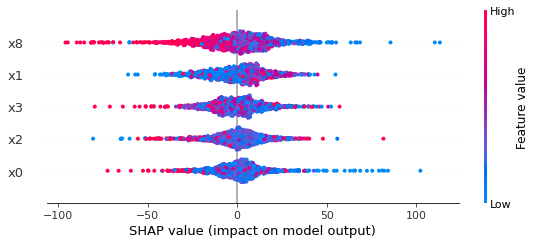

root - INFO - Getting value for save_shap_summary_plot
root - INFO - Setting value for importance_df
root - INFO - Getting value for importance_df
root - INFO - Getting value for importance_df
root - INFO - Getting value for importance_df
root - INFO - Getting value for importance_df
root - INFO - Setting value for importance_df
root - INFO - Getting value for importance_df
root - INFO - Getting value for importance_df
root - INFO - Getting value for n_features
root - INFO - Getting value for n_features
root - INFO - Getting value for importance_df
root - INFO - Getting value for importance_df


    0          1
0  x0  10.285166
1  x1  12.092601
2  x2  10.457346
3  x3  11.004252
4  x4   8.586718
5  x5   1.471068
6  x6  10.074565
7  x7   3.165593
8  x8  15.626504
  column_name shap_importance
0          x0       10.285166
1          x1       12.092601
2          x2       10.457346
3          x3       11.004252
4          x4        8.586718
5          x5        1.471068
6          x6       10.074565
7          x7        3.165593
8          x8       15.626504
  column_name shap_importance
8          x8       15.626504
1          x1       12.092601
3          x3       11.004252
2          x2       10.457346
0          x0       10.285166
6          x6       10.074565
4          x4        8.586718
7          x7        3.165593
5          x5        1.471068
  column_name shap_importance
8          x8       15.626504
1          x1       12.092601
3          x3       11.004252
2          x2       10.457346
0          x0       10.285166


In [20]:

pipeline = Pipeline([
            # feature selection
            ('grid_xgbse', grid_xgbse),

 ])

X_train=pipeline.fit_transform(X_train,y_train_fs)


# Transform X_test

X_train already transformed (features already selected), it is time to transform X_text



In [21]:
X_test = pipeline.transform(X_test)

# Prepare for using XGBSEKaplanNeighbors and fit the model

Note that features already selected by the above pipeline


In [22]:
PARAMS_TREE = {
    'objective': 'survival:cox',
    'eval_metric': 'cox-nloglik',
    'tree_method': 'hist',
    'max_depth': 10,
    'booster':'dart',
    'subsample': 1.0,
    'min_child_weight': 50,
    'colsample_bynode': 1.0
}

xgbse_model = xgbse.XGBSEKaplanNeighbors(PARAMS_TREE)
xgbse_model.fit(X_train, y_train, time_bins=TIME_BINS)
mean, upper_ci, lower_ci  = xgbse_model.predict(X_test,return_ci=True)



# To easily plot confidence intervals


In [23]:
# to easily plot confidence intervals
def plot_ci(mean, upper_ci, lower_ci, i=42, title='Probability of survival $P(T \geq t)$'):

    # plotting mean and confidence intervals
    plt.figure(figsize=(12, 4), dpi=120)
    plt.plot(mean.columns,mean.iloc[i])
    plt.fill_between(mean.columns, lower_ci.iloc[i], upper_ci.iloc[i], alpha=0.2)

    plt.title(title)
    plt.xlabel('Time [days]')
    plt.ylabel('Probability')
    plt.tight_layout()


# Check performance of the feature selector and model integrated

C-index: 0.6484779251097873
Avg. Brier Score: 0.1821951575473847


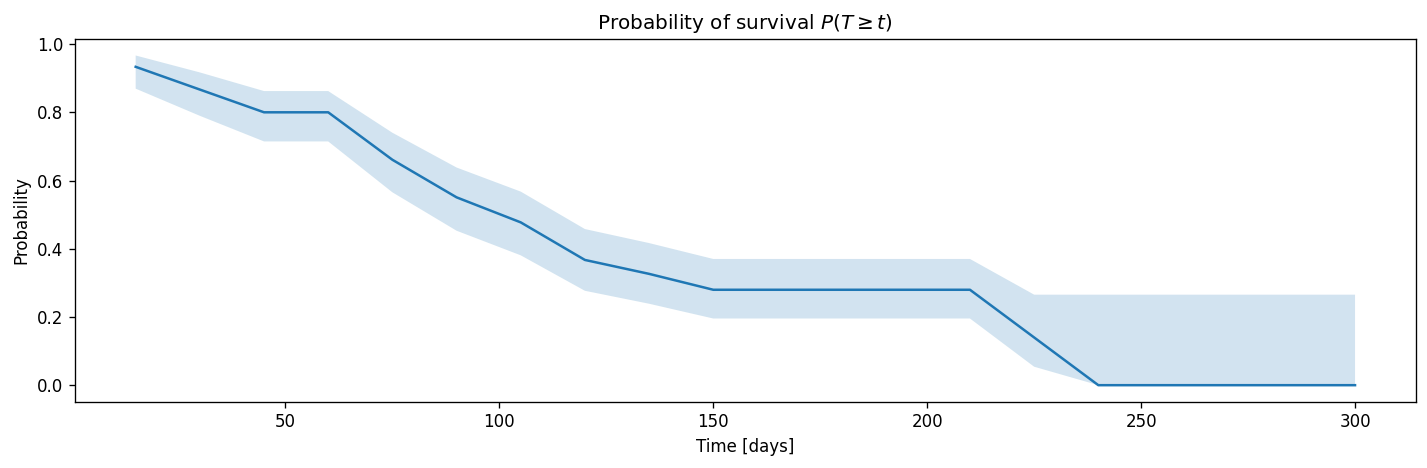

In [24]:
# print metrics
print(f"C-index: {concordance_index(y_test, mean)}")
print(f"Avg. Brier Score: {approx_brier_score(y_test, mean)}")

# plotting CIs
plot_ci(mean, upper_ci, lower_ci)



It is interesting to see that obtained results by using only selected five features are slightly better than in the original example in 

https://loft-br.github.io/xgboost-survival-embeddings/examples/confidence_interval.html

the model used all eight features with the same test and train data and parameters. 